# Data Science Project
###Predicting Long Customer Wait-Times with Customer Traffic and Weather Data
####Heather Hardway
#####May 2, 2015

####Summary: A key performance indicator for retail banks is the length of time customers wait in line before their transactions are processed.  Yet, often customers only show up in the data at the completion of their transaction (i.e. when they receive their receipt).  While new technology exists, such at security cameras enabled with tracking capabilities, such infrastructure is the exception, not the norm, at your neighborhood retail bank.  




####My project will be tied to understanding customer wait times and predicitng days with higher than average expected waits. A major obstacle is the lack of wait time data – only transactional data exists. However, a bank can be thought of as a basic queuing model with three key parameters -- arrival rate, service time, and the number of servers available. Wait times increase if the arrival rate of customers increases, while the remaining two paramters remain fixed.

####Looking at historical data, days and locations can be identified that had significantly higher customer volumes than predicted. It is reasonable to assume such increases coincide with longer wait-times.

####The second part will be combining the customer arrival patterns with weather data. Weather (both good and bad) influences traffic patterns, from highways to amusement parks. Is the same true of retail locations, such as banks? And if weather data can be utilized, would this lead to a better prediction of customer demand?

In [6]:
import pandas as pd
import numpy as np
from ggplot import *
%matplotlib inline
dd = pd.read_csv('/Users/heatherhardway/Documents/Data_Science/updated_fva_data.csv')
weatherdata = pd.read_csv('/Users/heatherhardway/Documents/Data_Science/clustered_weather_data.csv')

### The Data

In [154]:
dd[['Date', 'actual', 'forecast', 'City', 'State', 'Zip','ratio']].head(10)

,Date,actual,forecast,City,State,Zip,ratio
0,5/24/2014 0:00,147,127.632000,Branford,CT,6405,1.151749
1,9/5/2014 0:00,351,375.159003,Branford,CT,6405,0.935603
2,5/23/2014 0:00,438,340.409005,Branford,CT,6405,1.286687
3,5/22/2014 0:00,264,299.805995,Branford,CT,6405,0.880569
4,6/5/2014 0:00,292,404.255999,Branford,CT,6405,0.722315
5,6/4/2014 0:00,310,273.605997,Branford,CT,6405,1.133016
6,10/27/2014 0:00,214,229.956999,Branford,CT,6405,0.930609
7,5/21/2014 0:00,264,270.240998,Branford,CT,6405,0.976906
8,9/10/2014 0:00,281,234.126998,Branford,CT,6405,1.200203
9,9/9/2014 0:00,293,268.100000,Branford,CT,6405,1.092876


####Around 850 branches are included, for all operating days in 2014.  The locations are concentrated in the northeast, midatlantic, and south-central.  

####Using the Weather Source API, historial weather data was collected for all days in 2014.  However, the free version of the API significantly limits the number of calls per day (1000), which led to a need for clustering the branches into groups (not all 850 distinct locations could be called for all days).  Thus, 10 groups were clustered by longitude and latitude.

In [155]:
locales= pd.read_csv('/Users/heatherhardway/Documents/Data_Science/locales_cluster.csv')

Using the Weather Source API, weather data was obtained for clustered zipcodes for every day in 2014.  Below is summary of the metrics available (including "Cloud Cover Average", "Feels Like Avg", etc.)  However, the free version of the API significantly limits the number of calls per day (1000), which led to a need for clustering the branches into groups.

To reduce the number of calls to the API, branches were clusted into 10 groups, shown below in terms of longitude and latitude.  Colors represents the groups used to collect the weather data.

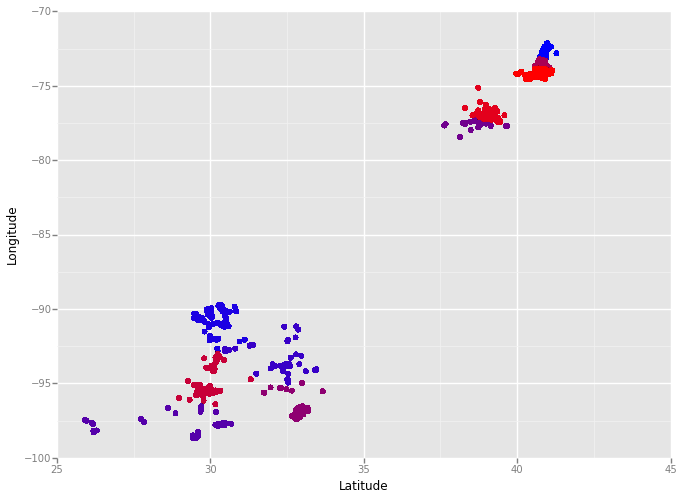

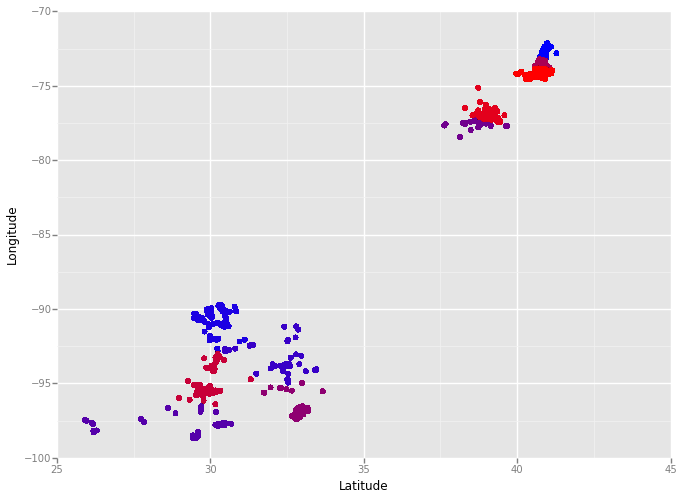

In [156]:
g = ggplot(locales, aes('Latitude', 'Longitude', color='predicted',label='predicted'))+geom_point()+scale_colour_gradient(low="red", high="blue")
g.draw()

In [157]:
weatherdata.head()

,Unnamed: 0,cldCvrAvg,cldCvrMax,cldCvrMin,country,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,...,tempMin,timestamp,wetBulbAvg,wetBulbMax,wetBulbMin,windSpdAvg,windSpdMax,windSpdMin,predicted,zips
0,0,51,79,20,us,24.6,30.6,17.5,33.9,42.8,...,27.1,2014-01-01T00:00:00-05:00,32.0,38.7,24.9,3.3,7.3,0.2,0,71107
1,1,81,96,40,us,31.1,33.5,28.3,31.4,36.0,...,30.8,2014-01-02T00:00:00-05:00,32.6,35.5,30.1,2.9,5.4,0.8,0,71107
2,2,46,100,3,us,9.8,28.0,1.7,10.5,25.6,...,14.6,2014-01-03T00:00:00-05:00,17.8,29.0,12.7,8.5,15.0,0.9,0,71107
3,3,22,100,1,us,11.4,17.0,6.1,18.3,26.2,...,12.2,2014-01-04T00:00:00-05:00,19.9,28.3,11.3,4.2,8.6,0.3,0,71107
4,4,83,100,27,us,30.2,36.8,16.5,32.3,36.7,...,29.1,2014-01-05T00:00:00-05:00,33.0,37.0,25.7,2.9,6.8,0.7,0,71107


####Sample of the weather data available -- everything from cloud cover to dew point average.

## Initial Data Analysis

In the following two graphs, high/avg/low volume days are deginated in blue/green/red, respectively.  The subplots are indexed by month (1-12) in the first plot and weekday (0=Monday, ..., 6=Sunday) in the second.

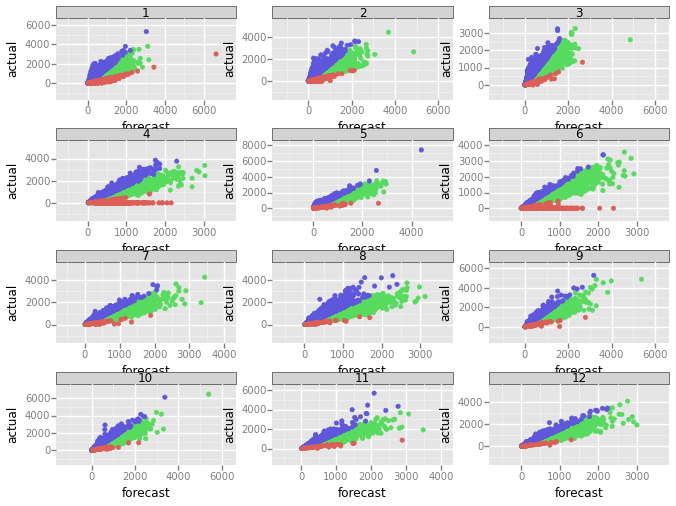

<ggplot: (704821053)>

In [158]:

ggplot(dd, aes(x='forecast', y='actual', colour='class_ratio'))+geom_point()+ facet_wrap('month')

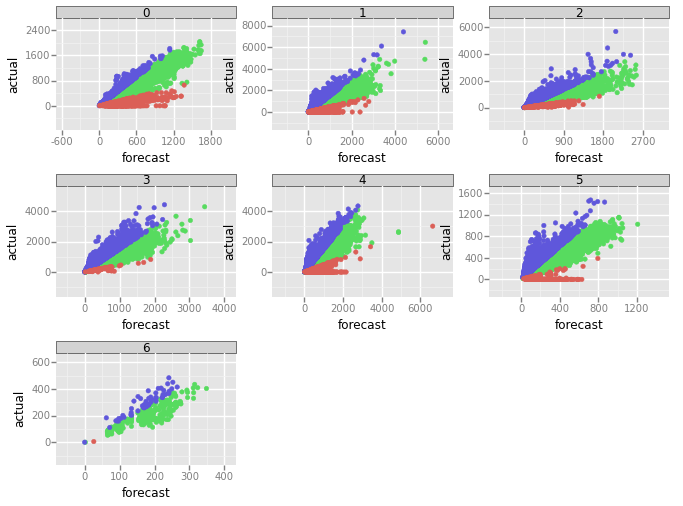

<ggplot: (895465877)>

In [159]:
ggplot(dd, aes(x='forecast', y='actual', colour='class_ratio'))+geom_point()+ facet_wrap('wday')

As indicated above there are more high volume days in months 1-3 (i.e. winter) and mid-week (weekdays 1-4, Tues-Fri).

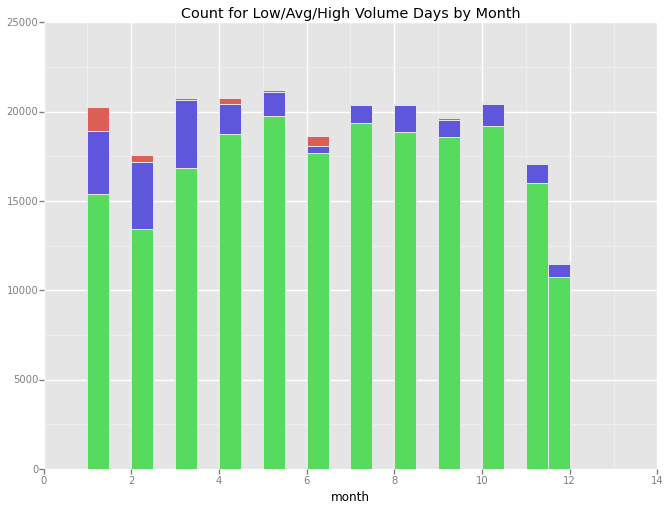

<ggplot: (902606481)>

In [160]:
ggplot(dd, aes(x='month', fill='class_ratio'))+geom_histogram(binwidth=.5)+ggtitle('Count for Low/Avg/High Volume Days by Month')

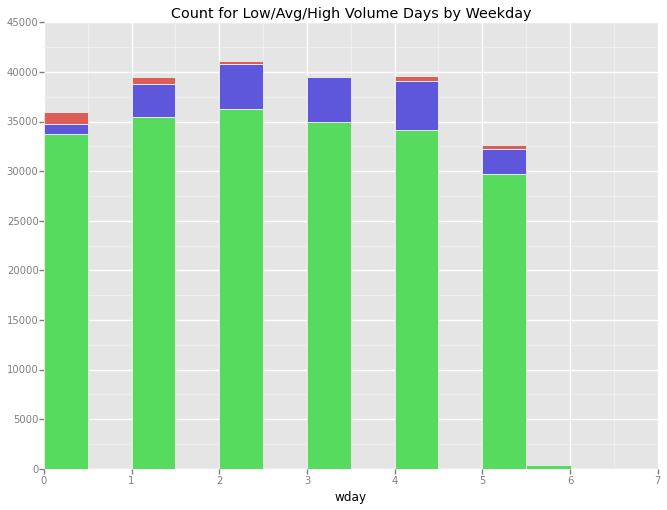

<ggplot: (909119517)>

In [161]:
ggplot(dd, aes(x='wday', fill='class_ratio'))+geom_histogram(binwidth=0.5)+ggtitle('Count for Low/Avg/High Volume Days by Weekday')

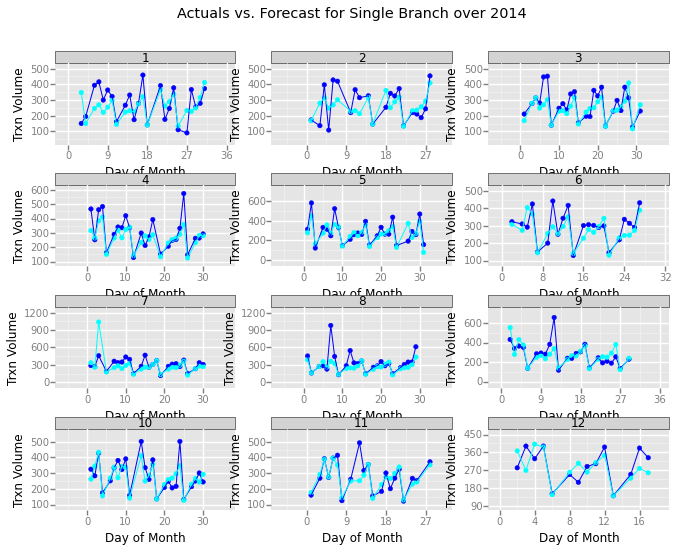

<ggplot: (909625173)>


In [162]:
samp = dd[dd.NewName==1]
sampm = pd.melt(samp[['day', 'month', 'forecast', 'actual']], id_vars=['day', 'month'])
print ggplot(sampm, aes(x='day', y='value', colour='variable'))+geom_point()+geom_line()+facet_wrap('month')+xlab('Day of Month')+ylab('Trxn Volume')+ggtitle('Actuals vs. Forecast for Single Branch over 2014')+scale_colour_manual(values=["blue","cyan"])

Looking in detail at a single branch, the red indicating actual volumes and blue forecast, the months of Jan and Feb look more volatile, with a number of days significantly above and below the forecast line.  This supports the premise that weather influnces the daily fluctuations of customer demand.  This is seen more dramatically for the full branch network on the next slide.

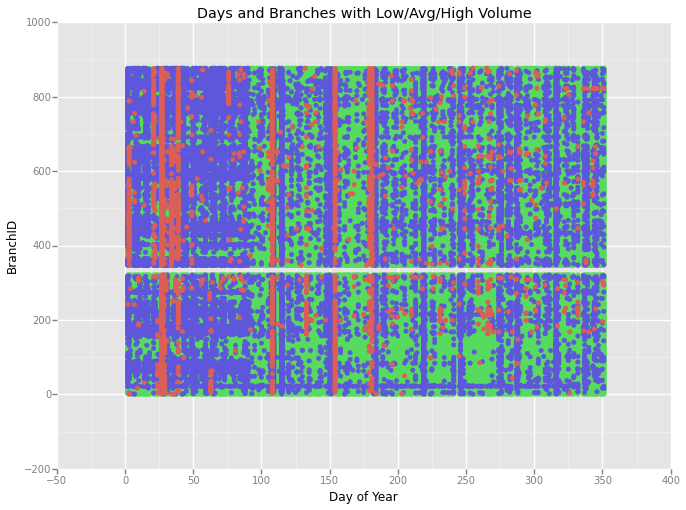

<ggplot: (934207717)>

In [179]:
ggplot(dd, aes(x='yday', y='NewName', colour='class_ratio'))+geom_point()+scale_color_gradient(low = 'red', high = 'blue')+xlab('Day of Year')+ylab('BranchID')+ggtitle('Days and Branches with Low/Avg/High Volume')

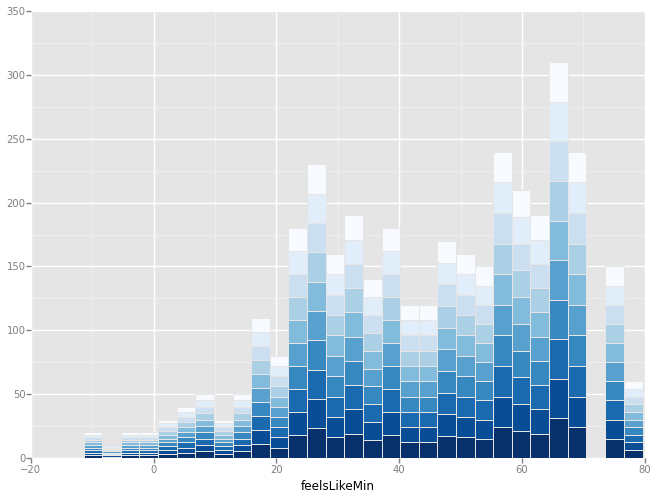

<ggplot: (880744581)>

In [164]:
ggplot(weatherdata, aes('feelsLikeMin', fill='predicted'))+geom_histogram()

Above is an example of metrics obtained from the weather data, such as "Feels Like Min" temperature.  As 10 different geographical regions were used, the "Feels Like Min" temperature distrubtion varies accross latitudes.

### Initial Model Building

As planned, the problem is a classification problem (classifying days/locations as high/avg/low customer volume), although this could also be a regression problem (if instead the customer traffic is set as the response).  Thus, I used the KNeighborsClassifier and KNeighborsRegressor for each situation, respectively. While further validation/optimzation is to be done, preliminary results suggest accuracy scores of each model of 90% and 83%.  However, futher inspection revealed very poor rates for classifying low and high volume days (the model is most accurate at predicting average volume days).  

Continued work will include exploring alternative models (Naeive Bayes, Logistic if reclassify values into two groups, other); normalizing data and testing the model dependence on scale; and further data validation (what to do with NaNs, etc.)


#Initial Model Building
#####Modeling -- As planned, the problem is a classification problem (classifying days/locations as high/avg/low customer volume), although this could also be a regression problem (if instead the customer traffic is set as the response).  Possible models thus include KNN, Decision Tree, Naieve Bayes, etc.

####Due to uneven distribution of classes (majority are considered "average"), I focused on Dececision Trees and variants thereof (Random Forests, Extra Trees, Gradient Boosted, etc.)


###Other Features Added
####Holidays
####Days to Holiday
####Weather information for "yesterday" and "tomorrow" (hurricanes, snowstorms are predicted in advance and could affect traffic both in advance of the event and in the aftermath of the event)
#####Actual transactions for "yesterday" (a slow day at a branch could affect the traffic the next day)

##Random Forest
#####After performing a grid-search on max-depth and n-estimators, the best model chosen was further analyzed in terms of its accuracy and feature improtance

In [2]:
import matplotlib.pyplot as plt


[[ 1.          0.          0.        ]
 [ 0.00708597  0.91521061  0.07770342]
 [ 0.          0.17291415  0.82708585]]


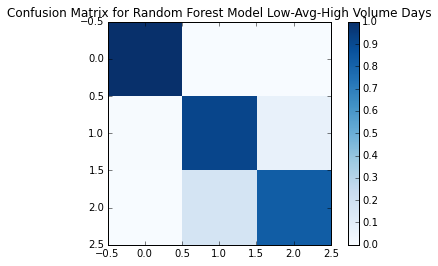

In [7]:
cm = np.array([[ 1.        ,  0.        ,  0.        ],
       [ 0.00708597,  0.91521061,  0.07770342],
       [ 0.        ,  0.17291415,  0.82708585]])

plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for Random Forest Model Low-Avg-High Volume Days')

print cm

In [8]:

cm_c = np.array([[  107,     0,     0],
       [  234, 30223,  2566],
       [    0,   143,   684]])
print cm_c

print (cm_c[0,0]+cm_c[1,1]+cm_c[2,2])/float(cm_c.sum())

[[  107     0     0]
 [  234 30223  2566]
 [    0   143   684]]
0.913331566393


#####The overall score of the model is 91.3%, with an accuracy within class of 100%, 92%, 83%.  While the "High class" (days that have higher than normal volume) has the highest error rate, almost all the incorrectly predicted classes are in the adjacent class.

#####The most important features are forecast (trxns), day of the year (yday), temperature average, temperature average tomorrow and month.  Surprisingly, the least important features are snowfall (today, tomorrrow or yesterday).

In [10]:
featuresi = pd.read_csv('/Users/heatherhardway/Documents/Data_Science/feature_table_random_forest.csv')
print featuresi.sort('impr', ascending=False).head(5)
print featuresi.sort('impr', ascending=False).tail(5)

    Unnamed: 0     features      impr
0            0     forecast  0.121947
4            4         yday  0.098655
8            8      tempAvg  0.087373
14          14  tempAvgtmrw  0.085700
2            2        month  0.067835
    Unnamed: 0      features      impr
12          12    preciptmrw  0.011819
19          19    precipystr  0.007962
7            7      snowfall  0.003434
13          13  snowfalltmrw  0.001742
20          20  snowfallystr  0.000423


###Conclusion
####Weather data does increase the predictive power of the model
####Average temperature has the greatest impact on model (of weather featuress)
####Future directions - use regression (on actuals rather than classes), reduce feature space, understand feature impact on model